In [10]:
from matplotlib import pyplot as plt
from tqdm import tqdm
import pandas as pd

In [30]:
SCALE = 10

## Load "Sčítání lidí"

In [61]:
dfs = pd.read_excel("sldb2021_pv_vek_pohlavi.xlsx").set_index("věk")

ages = []
genders = []

for n, row in tqdm(dfs.iterrows()):
    for m in range(row["muži"] // SCALE):
        genders.append("M")
        ages.append(n // 5 * 5)

    for f in range(row["ženy"] // SCALE):
        genders.append("F")
        ages.append(n // 5 * 5)

persons = pd.DataFrame({"vek": ages, "pohlavi": genders, "mark": False})

101it [00:00, 740.27it/s]


## Load deaths

In [117]:
dfd = pd.read_csv("data/DEMOMIGR_2005_2021_komplet.csv")
# We do not want break out by region
dfd = dfd[dfd["uzemi"] == "CZ"].drop(columns=["uzemi", "uzemi_text", "status", "status_text", "pohlavi_text", "vek_text"])

# We do not want other years
dfd = dfd[dfd["tyden"].str.split("-").str[0] == "2021"]

# We do not want summaries "Celkem"
dfd = dfd[dfd["pohlavi"] != "T"]

# Converting and "normalizing"
dfd["tyden"] = pd.to_datetime(dfd["tyden"] + '0', format="%Y-W%W%w")
dfd["vek"] = dfd["vek"].str.split("T").str[0].str.lstrip("Y").replace("_GE90", 90).astype(int)

dfd = dfd.rename(columns={"tyden": "datum"})

## Load vaccinations

In [148]:
dfo = pd.read_csv("data/ockovani-demografie.csv").drop(columns=["id", "vakcina", "vakcina_kod"])

# Runtime optimization
dfo = dfo.groupby(["datum", "vekova_skupina", "pohlavi"]).sum().reset_index()

# Converting and "normalizing"
dfo["datum"] = pd.to_datetime(dfo["datum"], format="%Y-%m-%d")
dfo["pohlavi"] = dfo["pohlavi"].replace("Z", "F")
dfo["vekova_skupina"] = dfo["vekova_skupina"].replace("80+", "80-120")
dfo = dfo.rename(columns={"pocet_davek": "hodnota"})

# Runtime optimization
dfo = dfo.groupby([pd.Grouper(key='datum', freq='W-SUN'), "pohlavi", "vekova_skupina"]).sum().reset_index()

## Quick look

In [43]:
persons

,vek,pohlavi,mark
0,0,M,False
1,0,M,False
2,0,M,False
3,0,M,False
4,0,M,False
...,...,...,...
1052325,20,F,False
1052326,20,F,False
1052327,20,F,False
1052328,20,F,False


In [119]:
dfd

,datum,vek,pohlavi,hodnota
1,2021-01-10,0,M,1
2,2021-01-10,0,F,3
4,2021-01-10,5,M,0
5,2021-01-10,5,F,1
7,2021-01-10,10,M,0
...,...,...,...,...
42800,2021-12-26,80,F,256
42802,2021-12-26,85,M,144
42803,2021-12-26,85,F,241
42805,2021-12-26,90,M,122


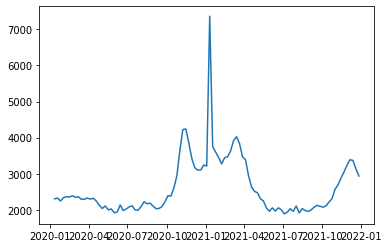

In [16]:
plt.plot(dfd.groupby("tyden").sum()["hodnota"]);

In [135]:
dfo

,datum,vekova_skupina,pohlavi,poradi_davky,hodnota
0,2020-12-27,18-24,M,1,23
1,2020-12-27,18-24,F,1,25
2,2020-12-27,25-29,M,1,36
3,2020-12-27,25-29,F,1,78
4,2020-12-27,30-34,M,1,48
...,...,...,...,...,...
19198,2022-09-26,70-74,F,19,101
19199,2022-09-26,75-79,M,27,85
19200,2022-09-26,75-79,F,22,73
19201,2022-09-26,80-120,M,26,62


## Model

- ještě mi to padá na nějaké chybě, ale po nalezení již by měl být hotový bod 1, 2, 4, 5

In [151]:
counts = []
counts_marked = []

In [152]:
days = sorted(dfd["datum"].unique())

for day_n in tqdm(range(len(days))):
    day = days[day_n]

    # Mark newly vaccinated
    for n, row in dfo[dfo["datum"] == day].iterrows():
        if row.hodnota > 0:
            vek = row.vekova_skupina.split("-")

            fi = persons[
                (persons["pohlavi"] == row.pohlavi) &
                (persons["vek"].isin(range(int(vek[0]), int(vek[1]) + 1))) &
                (~persons["mark"])
            ]

            persons.loc[persons.index.isin(fi), "mark"] = True

    # Remove dead people
    for n, row in dfd[dfd["datum"] == day].iterrows():
        if row.hodnota > 0:
            fi = persons[(persons["pohlavi"] == row.pohlavi) & (persons["vek"] == row.vek)].sample(n=row.hodnota).index
            persons = persons[~persons.index.isin(fi)]

    counts.append(len(persons))
    counts_marked.append(sum(persons["marked"] == True))

    break

  0%|          | 0/51 [00:00<?, ?it/s]

aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
aloha
b


  0%|          | 0/51 [00:06<?, ?it/s]


ValueError: Cannot take a larger sample than population when 'replace=False'